In [1]:
import numpy             as np
import matplotlib.pyplot as plt

from src.odes           import ODE
from src.rates          import initialise_abs, calculate_rates
from scipy.integrate    import solve_ivp
from astropy            import constants

In [2]:
CO = 72-1
H2O = 37-1

x=[5,
28,
34,
36,
41,
55,
59,
64,
71,
73,
126,
132,
198,
204,
207,
281,
331]



In [3]:
## Physical constants
kB = constants.k_B.cgs.value          ## Boltzmann constant [erg/K]
mH = constants.u.to('g').value        ## mass H atom = atomic mass unit [g]

## Other constants
pi = np.pi

#-- GRAIN PARAMETERS FOR H2 FORMATION AND CR IONISATION
rGr    = 1.0E-5    ## grain radius [cm]
nGr    = 1.5e-12   ## grain number density/H2 (assuming gas/dust = 200, rho = 3.5 g/cm^3)
w      = 0.5       ## grain albedo
AUV_AV = 4.65
stckH  = 0.3       ## sticking coefficient for H atoms

In [4]:
## input values physics
ρ  = 1e+6
T  = 2500.
δ  = 1.
Av = 1.

## input chemistry
chemtype = 'C'

## calculate H accretion on dust
Haccr = stckH *pi*(rGr**2.0)*ρ*nGr*(8.0*kB*T/(pi*mH))**0.5

In [5]:
n, n_consv = initialise_abs(chemtype)
ndot       = np.zeros(len(n))
X          = np.zeros(len(n_consv))
k          = calculate_rates(T, δ, Av)

In [ ]:
t=0.0
# ODE(t, n, n_consv, ndot, X, k, ρ, Haccr)

In [ ]:
yr_to_sec = 3.14*1e7  

Δt = 1.0e+2*yr_to_sec  ## in sec
# y0 = np.random.randn(2)

# a = 1.3
# b = 5.2

solution = solve_ivp(
    fun          = ODE,
    t_span       = [0.0, Δt],
    y0           = n,
    method       = 'BDF',   ## zoals DVODE
    args         = (n_consv, ndot, X, k, ρ, Haccr),
    dense_output = False    ## if True: returns interpolation function
)

assert solution['status'] == 0

ys = solution['y']
ts = solution['t']

print(solution['message'])

AssertionError: 

(1e-40, 1.0)

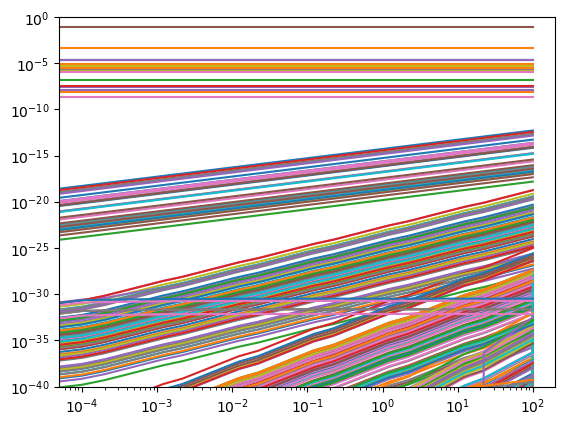

In [ ]:
for i in range(ys.shape[0]):
    plt.plot(ts, ys[i])
# for j in x:
#     plt.plot(ts, ys[j],'k')
plt.yscale('log')
plt.xscale('log')

plt.ylim((1.0e-40, 1.0e+0))
